---
# Preparation
---

##Import Libraries

In [111]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from typing import List, Tuple


##Functions for loading and displaying images

Provided is a function to download images from a url and downsize it appropriately. There is also a basic function to show images, but this should be used for debugging because it does not include labels.

TODO: function generate noise image, function to plot images side by side (or in matrix).

In [112]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Display an image, mainly for debugging since it is unlabeled
def show(img):
    display.display(PIL.Image.fromarray(np.uint8(img)))

# Return an (RGB) image of random values
def noisy_image(shape: Tuple[int]=(500, 500, 3)):
    #TODO return a random matrix in RGB format of the specified size.
    imarray = np.random.randint(256, size=shape)

    return imarray

def show_side_by_side(images: List, figsize: Tuple[int]=(22, 12), titles: List[str]=None):
    fig, axs = mpl.pyplot.subplots(1, len(images), figsize=figsize)
    # TODO Implement a function to plot a list of images side by side (to show the evolution of our
    # algorithm). Make sure you can title each figure using the 'titles' input
    # THIS IS A SUGGESTION. You may plot however you see fit, but this format should be helpful
    for i in range(len(images)):
        axs[i].title.set_text(titles[i])
        axs[i].imshow(images[i])
        axs[i].axis('off')
    

## Data
### Problem [1ab]
Load any images you want to use, and display them. This includes generating the noisy image and having a working plot function.

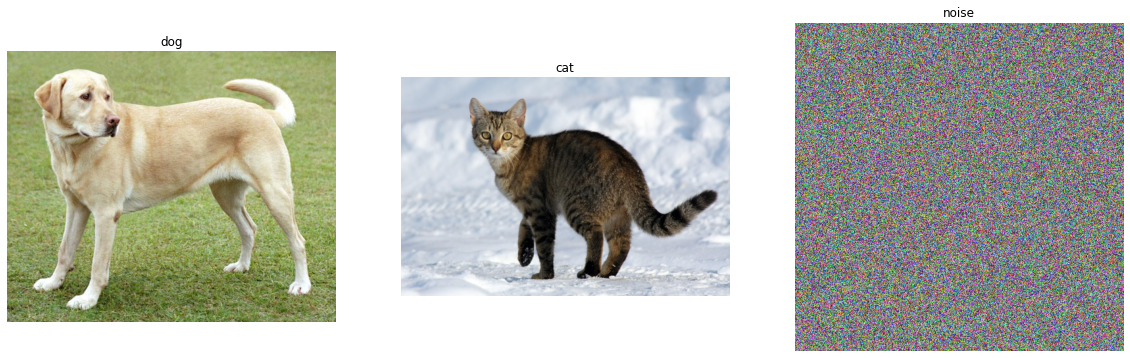

In [113]:
# Put any images you want to "dream" here, then form the urls into a list so we can process all of
# them easily, and add more/less without changing the following code
dog_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
cat_url = "https://upload.wikimedia.org/wikipedia/commons/b/b6/Felis_catus-cat_on_snow.jpg"
urls = [dog_url, cat_url]

# lets set a max pixel width/height so the network runs easier
max_dim = 500
# lets download from our urls, and resize as needed
images = [download(url, max_dim=max_dim) for url in urls]
# then lets also put a noisy image in to the list, also with the max size specified
images.append(noisy_image(shape=(max_dim, max_dim, 3)))

# Lets make sure we have the right stuff
show_side_by_side(images, figsize=(20,10), titles=['dog','cat','noise'])

## Load model, and write a deprocessing functionRGB

### Problem 1 [cd]
Write a function to return from data formatted for InceptionV3 as RGB format 

> InceptionV3 takes float values between -1.0 and 1.0

> RGB is integer valued between 0 and 255 (inclusive)

In [114]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# The preprocessing converts values to between -1.0 and 1.0
def preprocess(img):
    return tf.keras.applications.inception_v3.preprocess_input(img)

# To get back to proper values, we need to 
# a) change to be 0.0 to 2.0
# b) change to be 0.0 to 1.0
# c) change to be 0 to 255, and cast to int
def deprocess(img):
    # TODO implement to convert back to RGB
    return np.rint(((img + 1)/2) * 255).astype('uint8')

# Sanity check on part of the image, make sure your functions invert one another 
print('original\n', images[0][0:3,0])
print('pre(original)\n', preprocess(images[0][0:3,0]))
print('dep(pre)\n', deprocess(preprocess(images[0][0:3,0])))


original
 [[160 165  99]
 [155 160  95]
 [149 154  90]]
pre(original)
 [[ 0.254902    0.2941177  -0.2235294 ]
 [ 0.21568632  0.254902   -0.25490195]
 [ 0.1686275   0.20784318 -0.29411763]]
dep(pre)
 [[160 165  99]
 [155 160  95]
 [149 154  90]]


---
# Deep Dream Algorithm (basic)
---

## Choose which of the layers to maximize.
### Problem 2 [abc]

>A) Extract 1-4 layers of interest from InceptionV3, and create a Tensorflow model
that takes image input and outputs the activations of these layers.
>
>B) Record the layers you (initially) picked to "dream" from

>> 'mixed0', 'mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5'

>C) Explain what you expect to happen to the output image as you pick layers that
are deeper (layer 0 is the shallowest, layer 11 is the deepest). (hint: think back to CNN’s
in HW 1 - what layer usually follows a convolution, and what does it do?)


>> Deeper layers respond to higher-level features (such as eyes and faces).






See [```Tf.keras.Model```](https://www.tensorflow.org/api_docs/python/tf/keras/Model#get_layer). Also look at ```tf.keras.Model.get_layer()``` on the same link.

In [115]:
def extract_layers(layer_numbers: List[int]):
    # TODO: extract the appropriate layers and put them into a Tensorflow model.
    # Note: The model is already trained, so by making a new model all we are really doing is
    # making a way to output values from the layers that the original model does NOT output, since 
    # its job was classification
    layers = [base_model.get_layer('mixed' + str(number)).output for number in layer_numbers]

    return tf.keras.Model(inputs=base_model.input, outputs=layers)

# Build that model with your layers of choice
# TODO: change the layers. The starting code will only remove layer 0, which is inadequate.
dream_model = extract_layers([0, 1, 2, 3, 4, 5])

## Function to calculate the "Loss"

### Problem 3 [abcd]

>A) What is the loss function?

>>The loss function is the sum of the activation functions in the chosen layers.


>B) What normalizing step needs to be taken in the loss function?

>>The means of activation functions in the chosen layers are calculated respectively. The means are summed up and returned as the normalized value.


>C) Code 
>
>D) Are we trying to maximize or minimize this loss? Why does your answer make sense in terms of visualizing what the network has learned? (READ THE BLOG!)

>>We are trying to maximize the loss via gradient ascent. Thus, it enables finding "less meaningful" patterns within the data for NN model possible. When the CNN go over the chosen layers to find patterns, the model will "overinterpret" the patterns of the image, while making these "less meaningful" focus area sharper.


When writing your loss, be sure to use appropriate functions such as ```tf.reduce_sum``` and ```tf.math.reduce_mean``` instead of ```sum``` or ```mean``` because these special keras functions reduce the dimensions of the input. 



In [116]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Convert the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)

    # TODO use the model to generate layer activation values (it should just be model output)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
    print('Activation Values (Layer Output) = \n', layer_activations)
    print('Activation Shape = \n', np.shape(layer_activations))

    # TODO: Calculate the loss from the activation values
    losses = []
    for act in layer_activations:
        # calculate the mean of each activation
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    print('Losses (from multiple activation layers = )', losses)
    print('Losses shape (from multiple activation layers =)', np.shape(losses))
    print('Sum of all losses (from all selected layers=)', tf.reduce_sum(losses))

    # calculate sum
    return tf.reduce_sum(losses)

## Make a Tensorflow module that can be called on one image to perform DeepDream.
### Problem 4 [ab]
>A) Gradient
>> i) What is the gradient being computed?

>>> The derivative of the loss function with respect to the input image.



>> ii) Is the algorithm based on gradient descent? Explain how the algorithm works

>>> Instead of minimizing the loss with gradient descent, which is usually the case, with Deep Dream the loss is maximized with gradient "ascent". We rely on the loss calculated in the previous step, and then the gradient with respect to the given input image is calculated. Eventually, we add the gradient to the original image.


>B) Code
>> Print statements in the loop will be helpful to see what is happening, as this function may take a while to run in the future.



In [117]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    
    # Defines the input shapes to be 3 channels
    @tf.function(
        # ensure that the function is not retraced for different image sizes or steps/step_size values
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32), #images
            tf.TensorSpec(shape=[], dtype=tf.int32), # number of steps
            tf.TensorSpec(shape=[], dtype=tf.float32),)  # step size (like learning rate)
    )
    def __call__(self, img, steps, step_size):
        print('Tracing')
        # loss placeholder
        loss = tf.constant(0.0)

        # For each iteration, do one step of the algorithm
        for n in tf.range(steps):
            # Use the gradient tape to watch the input image (GradientTape records operations for automatic differentiation)
            with tf.GradientTape() as tape:
                # This needs gradients relative to 'img'
                # 'GradientTape' only watches 'tf.Variable's by default
                tape.watch(img)
                # Use your calc_loss function to get the loss
                loss = calc_loss(img, self.model)

            # TODO: calculate the gradient you need for deep_dream. 
            # If a tape wants to calculate dy/dx, you would call GradientTape.gradient(y,x)
            gradients = tape.gradient(loss, img)

            # TODO uncomment this line to normalize the gradients. 
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # TODO: Compute 1 step of the algorithm using these gradients. 
            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients * step_size

            # Make sure the image is valid InceptionV3 format still
            img = tf.clip_by_value(img, -1, 1)

        # return the final loss and the edited image after all the the loops
        return loss, img

## "Main" function for deep dream usage.

### Problem 5
This function should process ONE image, and return (at least) a list of images at intervals specified by 'interval' and a list of losses. How you return them is up to you, and you may return any other values you find helpful for plotting or for the octaves computations.

In [118]:
def run_deep_dream_simple(img, dreammodule, steps=100, step_size=0.01, interval=100):
    # preprocess
    img = tf.convert_to_tensor(preprocess(img))
    step_size = tf.convert_to_tensor(step_size)

    # Finally, lets loop through the process of finding the gradients at those levels
    # and adding them to the image, but making sure we can get the image at interval.
    steps_remaining = steps
    step = 0
    result = {}
    while steps_remaining:
        # TODO - run deep dream for 'interval' steps and save its resulting loss/image.
        if steps_remaining > 500:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(interval)

        loss, img = dreammodule(img, run_steps, tf.constant(step_size))
        steps_remaining -= run_steps
        step += run_steps

        # TODO - return the list of images and losses + anything else. Returning as a dict might
        # be helpful if you feel your code is getting messy.
        key = 'Step {:d}, loss {:.2f}'.format(step, loss)
        result[key] = deprocess(img)

        #display.clear_output(wait=True)
        #show(deprocess(img))

    return result


## Run your algorithm on each image and display Results
### Problem 6

In [119]:
# Make one of these modules from your model.
deepdream = DeepDream(dream_model)
# TODO Run on each image in your original list

# Optional: you can populate this list so you don't have to rerun algorithm for each plot
results = []
for img in images:
    # TODO - choose your algorithm parameters
    result = run_deep_dream_simple(img, deepdream, steps=150, step_size=0.01, interval=50)
    results.append(result)
    

Tracing
Activation Values (Layer Output) = 
 [<tf.Tensor 'while/model_2/mixed0/concat:0' shape=(1, None, None, 256) dtype=float32>, <tf.Tensor 'while/model_2/mixed1/concat:0' shape=(1, None, None, 288) dtype=float32>, <tf.Tensor 'while/model_2/mixed2/concat:0' shape=(1, None, None, 288) dtype=float32>, <tf.Tensor 'while/model_2/mixed3/concat:0' shape=(1, None, None, 768) dtype=float32>, <tf.Tensor 'while/model_2/mixed4/concat:0' shape=(1, None, None, 768) dtype=float32>, <tf.Tensor 'while/model_2/mixed5/concat:0' shape=(1, None, None, 768) dtype=float32>]
Activation Shape = 
 (6,)
Losses (from multiple activation layers = ) [<tf.Tensor 'while/Mean:0' shape=() dtype=float32>, <tf.Tensor 'while/Mean_1:0' shape=() dtype=float32>, <tf.Tensor 'while/Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'while/Mean_3:0' shape=() dtype=float32>, <tf.Tensor 'while/Mean_4:0' shape=() dtype=float32>, <tf.Tensor 'while/Mean_5:0' shape=() dtype=float32>]
Losses shape (from multiple activation layers =) (6

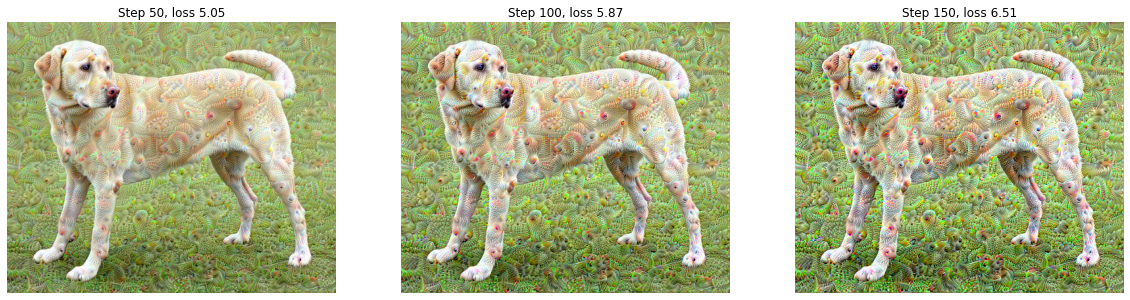

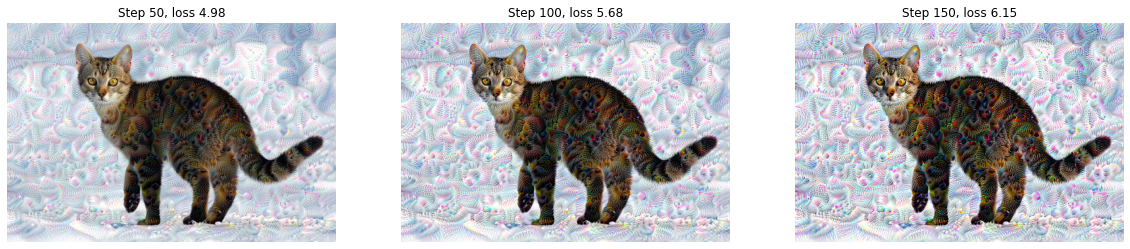

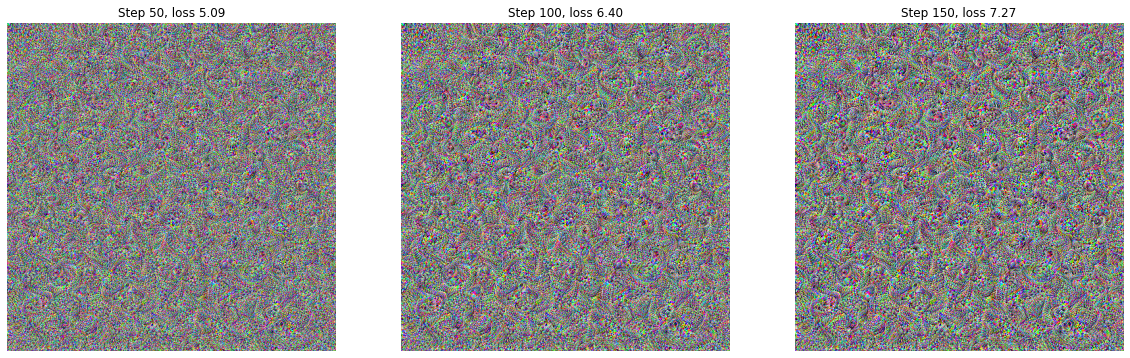

In [120]:
for result in results:
    # TODO Use your results to display the images as the algorithm changes it over time
    show_side_by_side(list(result.values()), figsize=(20, 10), titles=list(result.keys()))

## Noise Image comparison

### Problem 7

Read the blog to help find an explanation for the result of your noisy image vs theirs.


1.   The extratced layers of Inception V3 are different. I use 'mixed0', 'mixed1', and 'mixed2' to implement deep dream. The examples of the blog might extract higher level layers so that more sophisticated features of images were displayed.


2.   The iteration of deep dreaming are different. In my implementation, the model ran for 100 steps. For the examples of the blog, not only the algorithm is run for more iterations, but also some zooming is applied. Therefore, an endless stream of new impressions from the image is acquirable




## Parameter Play
### Problem 8
I tried both increasing the number of iteration cycle and shrinking the step size. Increasing the iterations will cause the model to generate a darker, more obvious pattern on the image. On the other hand, shrinking the step size generates a deep dreamed image with a more sophisticated pattern (i.e., more details) and less noise/randomness occurring.

Tracing
Activation Values (Layer Output) = 
 [<tf.Tensor 'while/model_3/mixed0/concat:0' shape=(1, None, None, 256) dtype=float32>, <tf.Tensor 'while/model_3/mixed2/concat:0' shape=(1, None, None, 288) dtype=float32>, <tf.Tensor 'while/model_3/mixed4/concat:0' shape=(1, None, None, 768) dtype=float32>, <tf.Tensor 'while/model_3/mixed6/concat:0' shape=(1, None, None, 768) dtype=float32>]
Activation Shape = 
 (4,)
Losses (from multiple activation layers = ) [<tf.Tensor 'while/Mean:0' shape=() dtype=float32>, <tf.Tensor 'while/Mean_1:0' shape=() dtype=float32>, <tf.Tensor 'while/Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'while/Mean_3:0' shape=() dtype=float32>]
Losses shape (from multiple activation layers =) (4,)
Sum of all losses (from all selected layers=) Tensor("while/Sum:0", shape=(), dtype=float32)


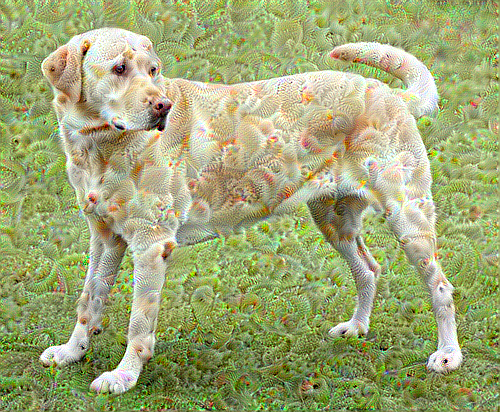

In [121]:
dream_model_v2 = extract_layers([0, 2, 4, 6])
deepdream_v2 = DeepDream(dream_model_v2)
#results_v2 = []
#for img in images:
#    result = run_deep_dream_simple(img, deepdream_v2, steps=1000, step_size=0.01, interval=100)
#    results_v2.append(result)

#for result in results_v2:
#    show_side_by_side(list(result.values()), figsize=(20, 10), titles=list(result.keys()))
result = run_deep_dream_simple(images[0], deepdream_v2, steps=1000, step_size=0.001, interval=100)
keys = list(result.keys())
show(result[keys[len(keys) - 1]])

---
# GRAD/ECE272B
---

## Octaves

### Grad Problem 1
>A) Read the section from the Tensorflow tutorial on octaves. Why does resizing the image as we go "allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.". (hint: we are still looking at the same layers as in the basic algorithm, so depth is not a factor.)

>>The target image is downscaled multiple times first, and then the deep dream model will create some patterns in the image that are relatively larger (because they are generated on a smaller image). As we upscale the target image and continue to apply deep dream, we actually get refined results (i.e., patterns within patterns like fractal). The generated pattern will become more obvious as we repeat the process (deep dream, upscale and incorporation).

>B) code: This function should take ONE image, and return a list of images and losses from the end of each octave. 
>Using ```run_deep_dream_simple()``` should be easy to integrate here for most of the heavy lifting (set 'interval' to 'octave_steps' so that ```run_deep_dream_simple()``` returns a list of just 1 image and loss value.)


In [122]:
def run_deep_dream_octaves(img, dreammodule, octave_scale=1.3, octave_steps=50, n_octaves=3, step_size=0.01):

    # Original image shape, as int and float
    base_shape =  tf.shape(img)[:-1]
    float_base_shape = tf.cast(base_shape, tf.float32)

    # TODO - write a function that takes an image and returns it to the original shape
    def restore(img):
        img = tf.image.resize(img, base_shape)
        img = tf.image.convert_image_dtype(image=img/255.0, dtype=tf.uint8)

        return img
    
    # TODO - write a function that takes an image and an octave number to calculate the 
    # new image size and cast to that size.
    def scale(img, octave):
        new_shape = tf.cast(float_base_shape * (octave_scale**octave), dtype=tf.int32)
        img = tf.image.resize(img, new_shape).numpy()

        return img

    # TODO - choose the powers to scale your octaves by based on `n_octaves` (see tutorial)
    powers = range(n_octaves)
    octave_result = {}

    for n in powers:
        img = scale(img, n)
        # TODO: run the basic algorithm on this scaled image
        result = run_deep_dream_simple(img=img, dreammodule=dreammodule, steps=octave_steps, step_size=step_size, interval=50)
        result_keys = list(result.keys())
        img = result[result_keys[len(result_keys) - 1]]
        # TODO - keep track of the updated image for output (appropriately sized using `restore`) 
        # and the loss
        key = ('Octave: {}, ' + result_keys[len(result_keys) - 1]).format(n)
        octave_result[key] = restore(img)
        #display.clear_output(wait=True)
        #show(restore(img))

    return octave_result


### Grad Problem 2

Run your octaves algorithm on each starting image and display them. This could almost be identical to problem 6.

In [123]:
# TODO Run on each image in your original list

# Optional: you can populate this list so you don't have to rerun algorithm for each plot
octave_results = []
for img in images:
    # TODO - choose your algorithm parameters
    result = run_deep_dream_octaves(img, deepdream, octave_scale=1.3, octave_steps=150, n_octaves=3, step_size=0.01)
    octave_results.append(result)
    

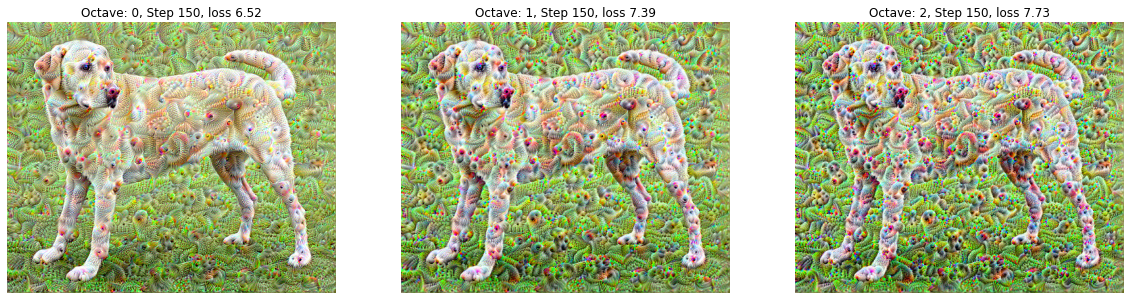

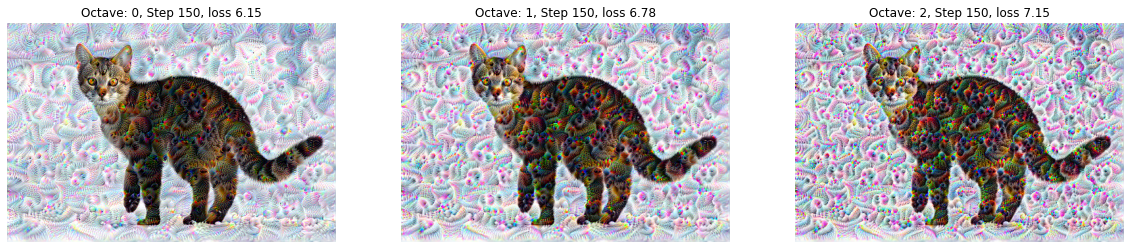

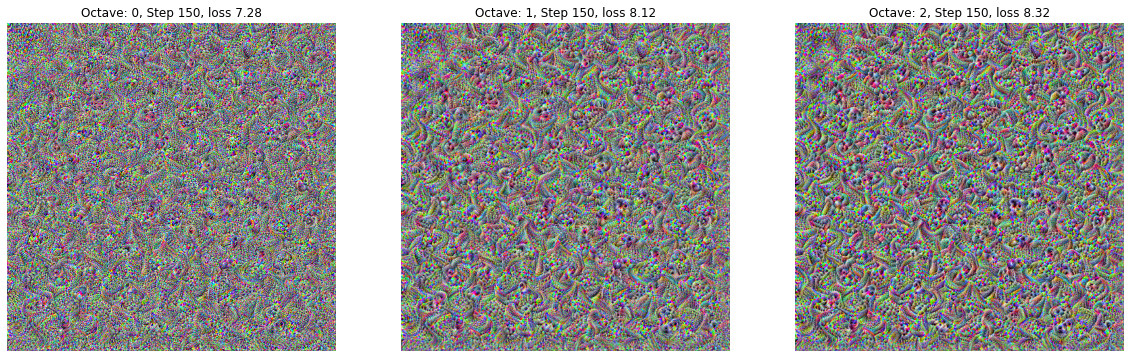

In [124]:
for result in octave_results:
    # TODO Use your results to display the images as the algorithm changes it over time
      show_side_by_side(list(result.values()), figsize=(20, 10), titles=list(result.keys()))